# ARCH vs GARCH model on S&P 500 Data

In [1]:
# pip install yfinance
# pip install arch
# pip install pmdarima

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import arch 
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Obtaining historic data on the SP500
sp = yf.download('^GSPC')


[*********************100%***********************]  1 of 1 completed


<Figure size 5000x4000 with 0 Axes>

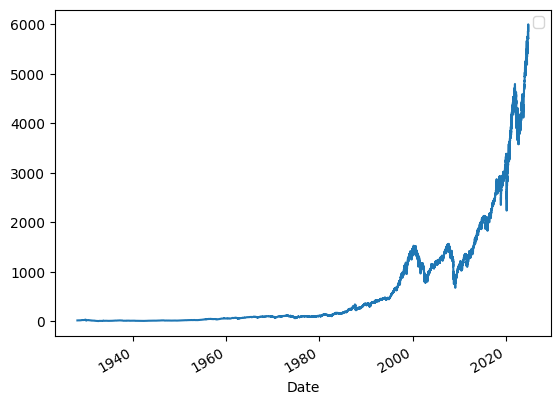

In [18]:
# Plotting the Adjusted Closing price for the SP500
plt.figure(figsize=(50,40))
sp['Adj Close'].plot()
# plt.title('Adjusted Close Price for the S&P 500 Index')
plt.legend('')
plt.show()

In [15]:
# Testing for stationary or non-stationary data 
adf_test = sm.tsa.stattools.adfuller(sp['Adj Close'])
print(f'p-value = {adf_test[1]}') # not stationary

p-value = 1.0


In [7]:
# Calculate log returns
series = np.log(sp['Adj Close']).diff().dropna()
series

Ticker,^GSPC
Date,
1928-01-03 00:00:00+00:00,0.005647
1928-01-04 00:00:00+00:00,-0.002255
1928-01-05 00:00:00+00:00,-0.009640
1928-01-06 00:00:00+00:00,0.006248
1928-01-09 00:00:00+00:00,-0.009101
...,...
2024-11-11 00:00:00+00:00,0.000969
2024-11-12 00:00:00+00:00,-0.002897
2024-11-13 00:00:00+00:00,0.000232


<Figure size 200x400 with 0 Axes>

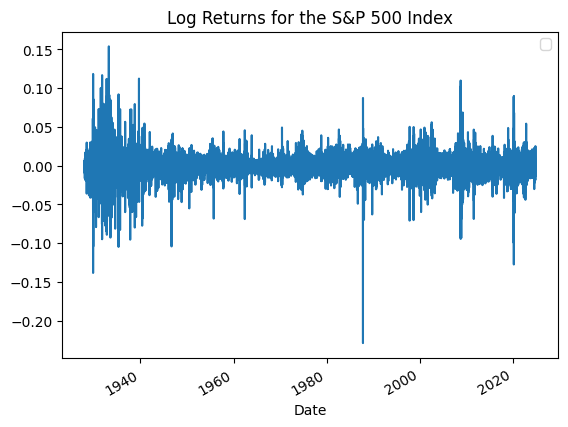

In [8]:
# Plot the log returns
plt.figure(figsize=(2,4))
series.plot()
plt.title('Log Returns for the S&P 500 Index')
plt.legend('')
plt.show()

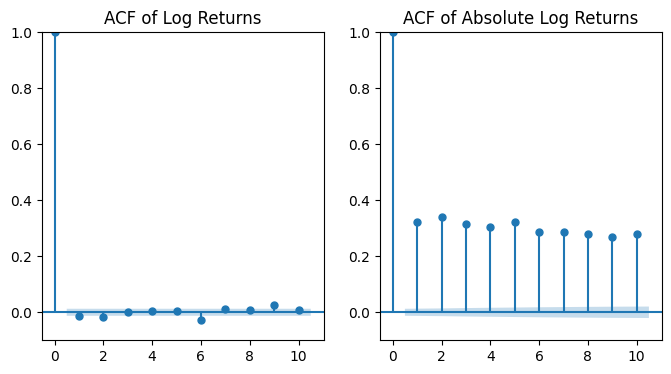

In [9]:
# Plot ACF plot of log returns
plt.rcParams["figure.figsize"] = 8, 4
fig, axes = plt.subplots(1, 2)
acf1 = plot_acf(series, lags=10, ax = axes[0])
axes[0].set_ylim((-0.1,1))
axes[0].set_title("ACF of Log Returns")

acf2 = plot_acf(abs(series), lags=10, ax = axes[1])
axes[1].set_ylim((-0.1,1))
axes[1].set_title("ACF of Absolute Log Returns")
plt.show()

In [59]:
# Find best model with auto arima
from pmdarima.arima import auto_arima
arima_model = auto_arima(series, 
                   seasonal=False,         # Set to True for seasonal data
                   trace=True,             # Show progress
                   error_action='ignore',  # Ignore errors
                   suppress_warnings=True, # Suppress warnings
                   stepwise=True)          # Faster estimation using stepwise approach

print(f"Best ARIMA Model: {arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-146374.802, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-146368.485, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-146369.686, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-146369.793, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-146372.188, Time=3.99 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-146372.286, Time=0.62 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-146365.840, Time=1.42 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-146366.921, Time=3.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-146370.666, Time=0.52 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-146370.841, Time=0.88 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-146370.298, Time=0.85 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-146366.276, Time=3.37 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-146382.568, Time=6.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-146380.419, Time=

In [64]:
# Extract AIC, number of parameters (k), and sample size (n)
aic = arima_model.aic()
n = len(series)
k = len(arima_model.arima_res_.params) 

# Compute AICc
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
print(f"AIC: {aic}")
print(f"AICc: {aicc}")

AIC: -146382.5676020685
AICc: -146382.56414939885


In [65]:
# Calculate residuals of ARMA(2,2) model
residuals = arima_model.resid()
s_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Get the absolute residuals
abs_residuals = abs(s_residuals)

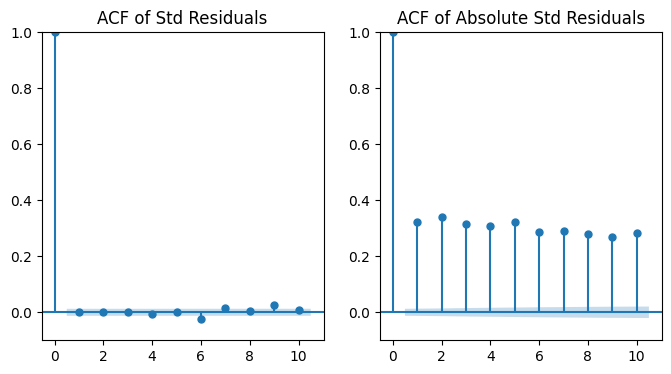

In [66]:
# Plot ACF plot of the residuals
plt.rcParams["figure.figsize"] = 8, 4
fig, axes = plt.subplots(1, 2)
acf1 = plot_acf(s_residuals, lags=10, ax = axes[0])
axes[0].set_ylim((-0.1,1))
axes[0].set_title("ACF of Std Residuals")

acf2 = plot_acf(abs_residuals, lags=10, ax = axes[1])
axes[1].set_ylim((-0.1,1))
axes[1].set_title("ACF of Absolute Std Residuals")
plt.show()

In [14]:
# test if there is autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  38.664868   0.000029


In [15]:
# test if there is autocorrelation
lb_test = acorr_ljungbox(abs_residuals, lags=[10], return_df=True)
print(lb_test)

         lb_stat  lb_pvalue
10  22252.920934        0.0


In [80]:
# Fit the GARCH(1, 1) model
from arch import arch_model
model = arch_model(series, vol='Garch', p=1, q=1, dist='t')  # Normal distribution
garch_fit = model.fit(disp='off')
# AIC: student -161049 normal -159288 

# Print the summary of the GARCH model
print(garch_fit.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        ^GSPC   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                80529.5
Distribution:      Standardized Student's t   AIC:                          -161049.
Method:                  Maximum Likelihood   BIC:                          -161008.
                                              No. Observations:                24336
Date:                      Mon, Nov 18 2024   Df Residuals:                    24335
Time:                              01:33:30   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

C:\Users\wongl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [81]:
# Get AIC and other required values
aic = garch_fit.aic  # Akaike Information Criterion (AIC)
n = len(series)  # Number of observations
k = len(garch_fit.params)  # Number of estimated parameters

# Calculate AICC (corrected AIC)
aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

print(f"AIC: {aic}")
print(f"AICC: {aicc}") #t: -161048.97, normal: -159287

AIC: -161048.97551199317
AICC: -161048.97304590192


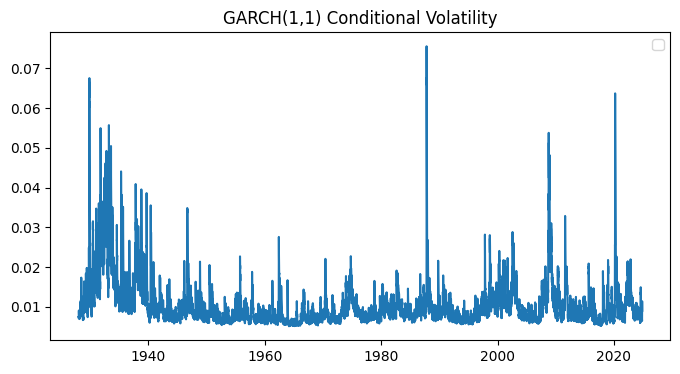

In [82]:
# Plot the conditional volatility
plt.figure(figsize=(8,4))
plt.plot(garch_fit.conditional_volatility)
plt.title('GARCH(1,1) Conditional Volatility')
plt.legend()
plt.show()

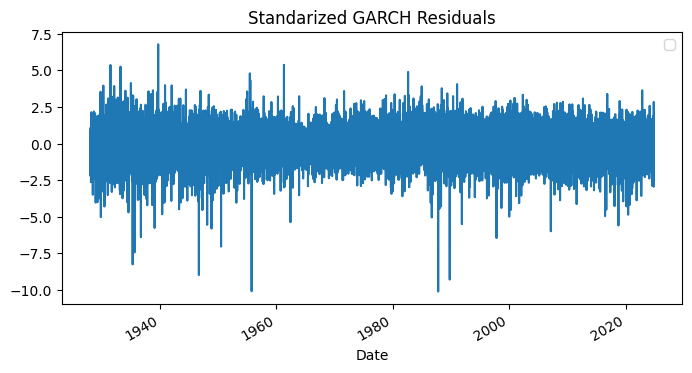

In [83]:
plt.figure(figsize=(8,4))
standardized_residuals.plot()
plt.title('Standarized GARCH Residuals')
plt.legend('')
plt.show()

In [84]:
# Extract the residuals (standardized residuals)
residuals = garch_fit.resid  # Raw residuals
standardized_residuals = garch_fit.resid / garch_fit.conditional_volatility  # Standardized residuals
abs_residuals = abs(standardized_residuals)

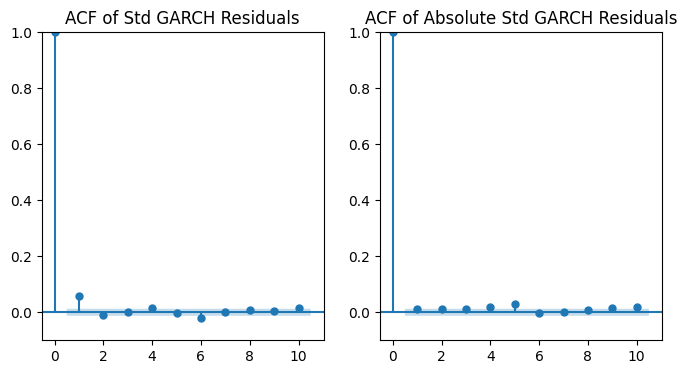

In [85]:
# Plot ACF plot of the residuals
plt.rcParams["figure.figsize"] = 8, 4
fig, axes = plt.subplots(1, 2)
acf1 = plot_acf(standardized_residuals , lags=10, ax = axes[0])
axes[0].set_ylim((-0.1,1))
axes[0].set_title("ACF of Std GARCH Residuals")

acf2 = plot_acf(abs_residuals, lags=10, ax = axes[1])
axes[1].set_ylim((-0.1,1))
axes[1].set_title("ACF of Absolute Std GARCH Residuals")
plt.show()

<Figure size 800x600 with 0 Axes>

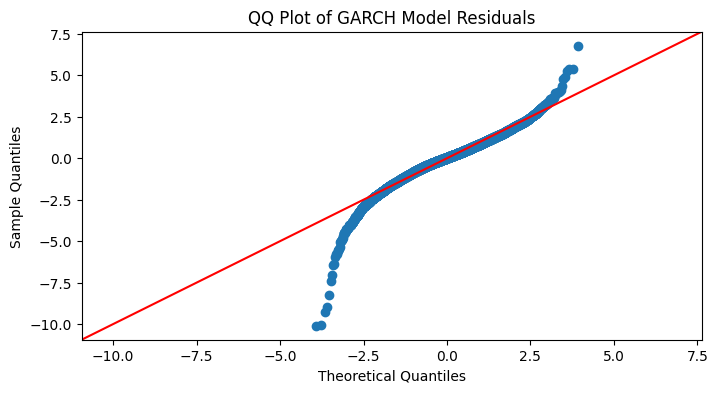

In [79]:
# plot qqplot
plt.figure(figsize=(8, 6))
sm.qqplot(standardized_residuals, line ='45')  # '45' line means 45 degree reference line for normality
plt.title('QQ Plot of GARCH Model Residuals')
plt.show()

In [88]:
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(residuals, maxlag=50)
shapiro_test = shapiro(s_residuals)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 0.0
F test p-value: 0.0
Shapiro-Wilks p-value: 3.105187834544259e-88


In [94]:
import seaborn as sns
from scipy.stats import norm

In [110]:
import scipy.stats as stats
excess_kurt = stats.kurtosis(series)
print("Excess Kurtosis:", excess_kurt)

# Calculate normal kurtosis (without subtracting 3)
normal_kurt = stats.kurtosis(series, fisher=False)
print("Normal Kurtosis:", normal_kurt)

Excess Kurtosis: [18.753077]
Normal Kurtosis: [21.753077]
